In [48]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [49]:
def load_data():
    df = pd.read_csv('/home/sina/ws_ai_codingcamp_2/employee-retention-predictive-model/HR.csv')
    return df

In [50]:
def handle_missing_values(df):
    numeric_imputer = SimpleImputer(strategy='mean')
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    df[numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])
    
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    categorical_columns = df.select_dtypes(include=['object']).columns
    df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])
    
    return df

In [51]:
def handle_outliers(df):
    numeric_columns = ['satisfaction_level', 'last_evaluation', 'number_project',
                      'average_montly_hours', 'time_spend_company']
    
    for column in numeric_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    
    return df

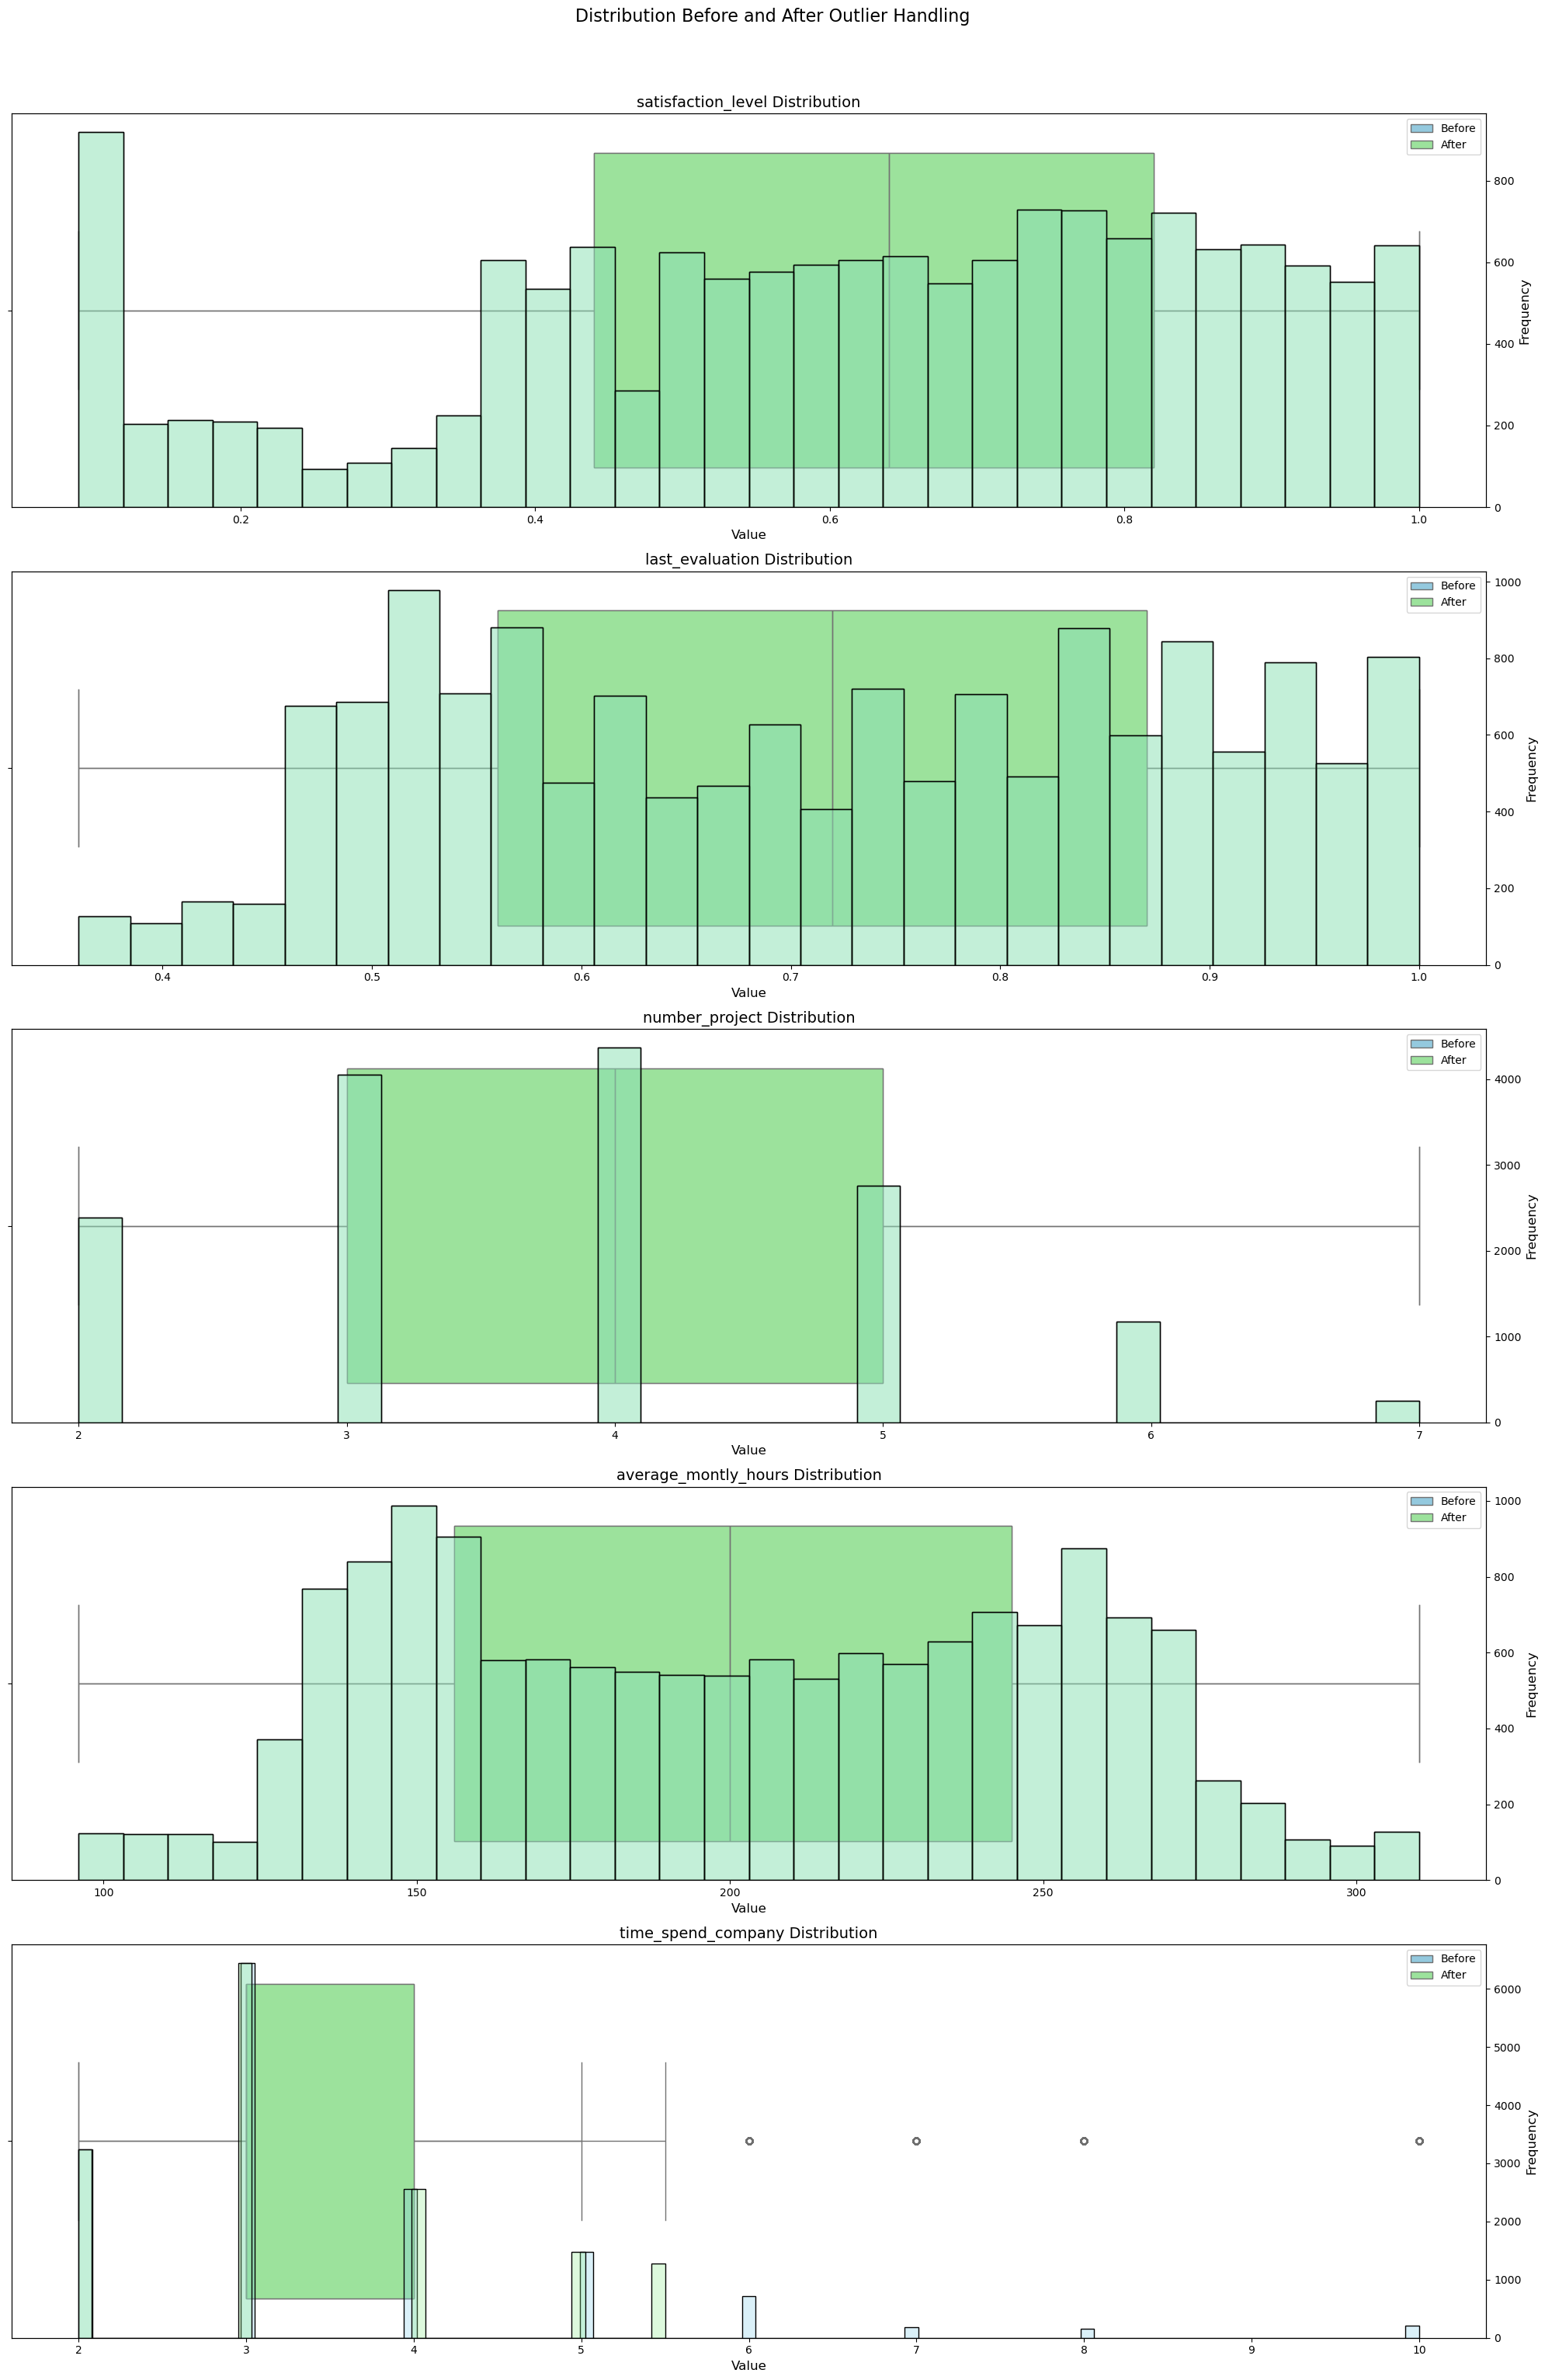

In [52]:
def plot_outlier_handling_results(df_original, df_processed):
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    numeric_columns = ['satisfaction_level', 'last_evaluation', 'number_project',
                      'average_montly_hours', 'time_spend_company']
    
    fig, axes = plt.subplots(len(numeric_columns), 1, figsize=(20, 6*len(numeric_columns)))
    fig.suptitle('Distribution Before and After Outlier Handling', fontsize=16, y=1.02)
    
    for idx, column in enumerate(numeric_columns):
        ax1 = axes[idx].twinx()
        
        sns.boxplot(x=df_original[column], color='skyblue', ax=axes[idx])
        sns.boxplot(x=df_processed[column], color='lightgreen', ax=axes[idx])
        
        sns.histplot(data=df_original[column], color='skyblue', alpha=0.3, ax=ax1)
        sns.histplot(data=df_processed[column], color='lightgreen', alpha=0.3, ax=ax1)
        
        axes[idx].set_title(f'{column} Distribution', fontsize=14)
        ax1.set_ylabel('Frequency', fontsize=12)
        axes[idx].set_xlabel('Value', fontsize=12)
        
        axes[idx].legend(['Before', 'After'])
    
    plt.tight_layout()
    plt.show()

df = load_data()
df_processed = handle_outliers(df.copy())
plot_outlier_handling_results(df, df_processed)

In [40]:
def encode_categorical_variables(df):
    encoders = {}
    categorical_columns = ['department', 'salary']
    
    for column in categorical_columns:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        encoders[column] = le
    
    return df, encoders

In [41]:
def scale_features(df):
    numeric_columns = ['satisfaction_level', 'last_evaluation', 'number_project',
                      'average_montly_hours', 'time_spend_company']
    
    standard_scaler = StandardScaler()
    df_standard = df.copy()
    df_standard[numeric_columns] = standard_scaler.fit_transform(df[numeric_columns])
    
    minmax_scaler = MinMaxScaler()
    df_minmax = df.copy()
    df_minmax[numeric_columns] = minmax_scaler.fit_transform(df[numeric_columns])
    
    return df_standard, df_minmax, standard_scaler, minmax_scaler

In [42]:
def create_features(df):
    df['work_intensity'] = df['average_montly_hours'] / df['number_project']
    df['satisfaction_evaluation_ratio'] = df['satisfaction_level'] / df['last_evaluation']
    df['projects_per_year'] = df['number_project'] / df['time_spend_company']
    
    return df

In [43]:
def prepare_supervised_data(df_standard, test_size=0.2, random_state=42):
    X = df_standard.drop('left', axis=1)
    y = df_standard['left']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    return X_train, X_test, y_train, y_test

In [44]:
# Cell 9: Clustering Data Preparation
def prepare_clustering_data(df_minmax):
    clustering_data = df_minmax.drop('left', axis=1)
    original_labels = df_minmax['left']
    
    return clustering_data, original_labels

In [45]:
def main():
    df = load_data()
    df = handle_missing_values(df)
    df = handle_outliers(df)
    df, encoders = encode_categorical_variables(df)
    df = create_features(df)
    df_standard, df_minmax, standard_scaler, minmax_scaler = scale_features(df)
    X_train, X_test, y_train, y_test = prepare_supervised_data(df_standard)
    clustering_data, original_labels = prepare_clustering_data(df_minmax)
    
    preprocessed_data = {
        'supervised': {
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test
        },
        'clustering': {
            'data': clustering_data,
            'original_labels': original_labels
        },
        'transformers': {
            'encoders': encoders,
            'standard_scaler': standard_scaler,
            'minmax_scaler': minmax_scaler
        }
    }
    
    import pickle
    with open('preprocessed_hr_data.pkl', 'wb') as f:
        pickle.dump(preprocessed_data, f)
    
    return preprocessed_data

In [46]:
if __name__ == "__main__":
    preprocessed_data = main()

In [47]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def load_data():
    df = pd.read_csv('/home/sina/ws_ai_codingcamp_2/employee-retention-predictive-model/HR.csv')
    df = df.rename(columns={'sales': 'department'})
    return df

def prepare_data(df):
    labels = df['left']
    data = df.drop('left', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(
        data, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    X_train = pd.get_dummies(X_train)
    X_test = pd.get_dummies(X_test)
    feature_names = X_train.columns.tolist()
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, feature_names, scaler

def main():
    df = load_data()
    X_train, X_test, y_train, y_test, feature_names, scaler = prepare_data(df)
    
    preprocessed_data = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'feature_names': feature_names,
        'scaler': scaler
    }
    
    import pickle
    with open('preprocessed_hr_data.pkl', 'wb') as f:
        pickle.dump(preprocessed_data, f)
    
    print("Training set size:", X_train.shape[0])
    print("Test set size:", X_test.shape[0])
    
    return preprocessed_data

if __name__ == "__main__":
    preprocessed_data = main()

Training set size: 11999
Test set size: 3000
